# Multi-Class Classification & Multi Label Classification Demonstrations

As a clothing retailer with an e-Commerce presence, it's important for us to understand what customers are saying about our products, which products are most popular with our customers, and how we can improve our offerings.



In [1]:
# Gereral Imports
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from timeit import timeit
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

# XGBoost
import xgboost as xgb

# Model Persistence Imports
from joblib import dump, load

# Test Processing Imports
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# SMOTE Imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Plotting Imports
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [4]:
df.shape

(23486, 8)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [5]:
# fill the NA values with empty string so that we don't drop rows that are only missing a title
df['Title'].fillna('', inplace=True)

In [6]:
# count of nulls
df.isnull().sum()

Age                          0
Title                        0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Department Name             14
Class Name                  14
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [9]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [10]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [11]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


## Check for Imbalanced Data

In [12]:
df['Department Name'].value_counts()

Tops        10048
Dresses      6145
Bottoms      3661
Intimate     1652
Jackets      1002
Trend         118
Name: Department Name, dtype: int64

In [13]:
filter = (df['Class Name'] == 'Chemises') | (df['Class Name'] == 'Casual bottoms')
df = df[~filter]

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [14]:
df['Text'][1]

' Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [15]:
def process_string(text):
    
    final_string = ""
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctionation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words and usless words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem the text with NLTK PorterStemmer
    stemmer = PorterStemmer() 
    text_stemmed = [stemmer.stem(y) for y in text_filtered]

    # Join the words back into a string
    final_string = ' '.join(text_stemmed)
    
    return final_string

In [16]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x))

In [17]:
df['Text_Processed'][1]

'love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit  love length hit littl knee would definit true midi someon truli petit'

# Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict whether a customer will recommend a product based on the text from the review and the sentiment of that text, and the length of the review.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline.

## Pipeline Building

In [18]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(), 'Text_Processed'),
             ('Text Length', MinMaxScaler(), ['text_len'])],
            remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),
                         ('clf', clf)])
     
    return pipeline

## Model Selection via Cross-Validation

In [19]:
X = df[['Text_Processed', 'text_len']]
y = df['Department Name']

In [20]:
print(X.shape)
print(y.shape)

(22624, 2)
(22624,)


In [21]:
le = LabelEncoder()
y = le.fit_transform(y)
y.shape

(22624,)

In [23]:
le.classes_

array(['Bottoms', 'Dresses', 'Intimate', 'Jackets', 'Tops', 'Trend'],
      dtype=object)

In [24]:
models = {'LogReg' : LogisticRegression(random_state=42, 
                                        class_weight='balanced', 
                                        max_iter=500),
          'RandomForest' : RandomForestClassifier(
                                        class_weight='balanced', 
                                        random_state=42),
          }

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3, 
                                 random_state=1)
    %time scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=cv, n_jobs=1, error_score='raise')
    print(name, ': Mean f1 Weighted: %.3f and Standard Deviation: (%.3f)' % \
        (np.mean(scores), np.std(scores)))

CPU times: user 1min 31s, sys: 13.9 s, total: 1min 44s
Wall time: 1min 29s
LogReg : Mean f1 Weighted: 0.817 and Standard Deviation: (0.006)
CPU times: user 5min 10s, sys: 4.28 s, total: 5min 15s
Wall time: 5min 15s
RandomForest : Mean f1 Weighted: 0.769 and Standard Deviation: (0.007)


## Model Training

In [25]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=53)

## Model Validation

In [26]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.YlOrBr)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('classification_' + name + '.png', dpi=300)  

              precision    recall  f1-score   support

           0      0.785     0.855     0.818      1193
           1      0.905     0.844     0.874      2037
           2      0.439     0.581     0.500       527
           3      0.551     0.794     0.650       315
           4      0.909     0.818     0.861      3361
           5      0.022     0.061     0.033        33

    accuracy                          0.810      7466
   macro avg      0.602     0.659     0.623      7466
weighted avg      0.836     0.810     0.820      7466



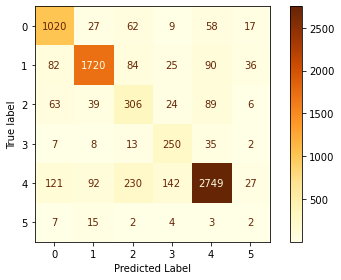

In [27]:
clf = LogisticRegression(random_state=42, 
                         class_weight='balanced', 
                         max_iter=500)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'Multiclass')

## Persist the Model

In [28]:
dump(pipeline, 'multiclass.joblib') 

['multiclass.joblib']

## Test on Custom Data

In [29]:
# Load the model
pipeline = load('multiclass.joblib')

In [30]:
def create_test_data(x):
    
    x = process_string(x)
    length = len(x)
    
    d = {'Text_Processed' : x,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [31]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
        'This skirt has really horible quality and I hate it!',
        'A super cute top with the perfect fit.',
        'The most gorgeous pair of jeans I have seen.',
        'this item is too little and tight.']

In [32]:
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', le.classes_[c_res[0]])

This dress is gorgeous and I love it and would gladly reccomend it to all of my friends. = Dresses
This skirt has really horible quality and I hate it! = Bottoms
A super cute top with the perfect fit. = Tops
The most gorgeous pair of jeans I have seen. = Bottoms
this item is too little and tight. = Intimate


## Multi-Label Classification

Next, we'll attempt to create a Supervised Machine Learning model to classify products by Department.  This process looks at the text that a user wrote in a review and determined its Department.

An interesting opportunity is to use this information to **cross-sell** or **cross-list** products.  If there is a strong enough probability that an item could be in multiple departments from our analysis, could we **increase sales** with cross-marketing?

In [33]:
# Tokenize the words
df['Department Name'] = df['Department Name'].apply(word_tokenize)

In [34]:
X = df[['Text_Processed', 'Department Name']]
y = df['Department Name']

In [35]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [36]:
mlb.classes_

array(['Bottoms', 'Dresses', 'Intimate', 'Jackets', 'Tops', 'Trend'],
      dtype=object)

In [37]:
def create_pipe(clf):
    
    # Create the column transfomer
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(), 'Text_Processed')],
            remainder='drop') 
    
    # Build the pipeline
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)), 
                         ('clf', clf)])
     
    return pipeline

In [42]:
models = {'Logistic Regression' : MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42)),
          'Random Forest' : MultiOutputClassifier(RandomForestClassifier(random_state=42))
          }

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    %time scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=3, n_jobs=1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

CPU times: user 13.1 s, sys: 5.86 s, total: 18.9 s
Wall time: 10.5 s
Logistic Regression : Mean f1 Macro: 0.589 and Standard Deviation: (0.012)
CPU times: user 3min 4s, sys: 2.63 s, total: 3min 7s
Wall time: 3min 7s
Random Forest : Mean f1 Macro: 0.413 and Standard Deviation: (0.008)


## Model Building & Validation

In [43]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1)

In [44]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(15158, 6)
(15158, 2)
(7466, 2)
(7466, 6)


In [45]:
clf = MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42))

pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro', zero_division=0)

print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.854     0.691     0.764      1214
           1      0.939     0.745     0.831      1996
           2      0.600     0.520     0.557       552
           3      0.674     0.604     0.637       336
           4      0.932     0.702     0.801      3335
           5      0.043     0.030     0.036        33

   micro avg      0.877     0.691     0.773      7466
   macro avg      0.674     0.549     0.604      7466
weighted avg      0.881     0.691     0.774      7466
 samples avg      0.679     0.691     0.683      7466



In [46]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Labels'] = pred_labels

In [63]:
# Display a random sample of them
# pd.set_option('display.max_colwidth', None)
X_test.sample(10, random_state=2)

,Text_Processed,Department Name,Predicted Labels
2356,stun color love blous color realli uniqu love ...,[Tops],"(Tops,)"
4073,absolut ador saw onlin said next time retail s...,[Dresses],"(Dresses,)"
13905,run small short size skirt great cute design ...,[Bottoms],"(Bottoms,)"
10098,great comfi shirt long enough wear leg,[Tops],"(Intimate, Tops)"
14467,small peopl cute concept larg realiti size j...,[Bottoms],()
6,cagrcoal shimmer fun ade basket hte last mintu...,[Tops],()
11381,nice vest itchi vest nice fashion stylish like...,[Tops],"(Jackets,)"
2438,comfort stylish great top older woman want sty...,[Tops],"(Tops,)"
5256,uniqu casual winner love top pair ag stevi sho...,[Tops],"(Tops,)"
1303,sad sack that look like wear dress sad sad sac...,[Dresses],"(Dresses,)"


In [65]:
filter = X_test['Predicted Labels'].apply(lambda x: len(x) > 1)
df_mo = X_test[filter]
df_mo

,Text_Processed,Department Name,Predicted Labels
17917,soft thick without bulk got mani compliment fi...,[Tops],"(Jackets, Tops)"
11460,love bought top size medium love super comfort...,[Tops],"(Intimate, Tops)"
10108,cute design poor materi love fact dress cotton...,[Dresses],"(Dresses, Intimate)"
12363,favorit hope love tunic isnt hope materi cute ...,[Tops],"(Jackets, Tops)"
13795,soft top reveal nonton arm fabric super soft g...,[Tops],"(Intimate, Tops)"
...,...,...,...
5830,good buy anoth pair bought wear christma parti...,[Bottoms],"(Bottoms, Intimate)"
1074,gorgeou high qualiti figur flatter swimsuit co...,[Intimate],"(Intimate, Tops)"
16306,pretti comfort airi top realli like design col...,[Tops],"(Intimate, Tops)"
3703,great fit comfort flashi love top soooooo much...,[Intimate],"(Intimate, Tops)"


## Test on New Data

In [66]:
def create_test_data(x):
    '''create a dataframe that is in the same format as the Train and Test Data.
    ['Bottoms' 'Dresses' 'Intimate' 'Jackets' 'Tops' 'Trend']'''
    
    s = process_string(x[0])
    
    d = {'Text_Processed' : s,
         'Department Name' : x[1]}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [67]:
revs = [('This dress is gorgeous and would gladly reccomend it to all of my friends.', ['Dresses']),
     ('These pants have really horible quality and I hate them!', ['Bottoms']),
     ('A super cute blouse with a great fit.', ['Tops']),
     ('The most gorgeous pair of jeans I have seen.', ['Bottoms']),
     ('This bra is silky smooth material and fits perfectly.', ['Intimate'])]

In [68]:
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev[0], '\n', rev[1], '\n' ,mlb.inverse_transform(c_res), '\n')

This dress is gorgeous and would gladly reccomend it to all of my friends. 
 ['Dresses'] 
 [('Dresses',)] 

These pants have really horible quality and I hate them! 
 ['Bottoms'] 
 [('Bottoms',)] 

A super cute blouse with a great fit. 
 ['Tops'] 
 [('Tops',)] 

The most gorgeous pair of jeans I have seen. 
 ['Bottoms'] 
 [('Bottoms',)] 

This bra is silky smooth material and fits perfectly. 
 ['Intimate'] 
 [('Intimate',)] 

